In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import vibronic_eigenstates.RK45_comparison as rkcomp
import vibronic_eigenstates as veigs
from scipy.integrate import RK45
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import ultrafastultrafast as uf2
import numpy as np

In [2]:
rk = rkcomp.RK45_compare('/Users/prose/VibronicEigenstatesPaper/dimer_for_scaling_test_d2_unsymmetric/',
                         mask_by_occupation_num = True)

In [3]:
import os

nmertype = 'trimer'
d = 0.2
manifold_num = 1

folder = '/Users/prose/VibronicEigenstatesPaper/{}_for_scaling_test_d{:.1f}/'.format(nmertype,d)

conv_eps_str = '1E-7'
# eg = veigs.EigenGenerator(folder,mask_by_occupation_num=True)

conv_arch = np.load(os.path.join(folder,'convergence'+conv_eps_str+'.npz'))

max_occ_num = conv_arch['max_occ_num']
num_eigvals = conv_arch['num_eigvals']
converged_truncation_sizes = conv_arch['converged_truncation_sizes']
timings = conv_arch['timings']
converged_hamiltonian_sizes = conv_arch['converged_hamiltonian_sizes']

rk = rkcomp.RK45_compare(folder,mask_by_occupation_num = True)

rk.set_H(truncation_size=int(converged_truncation_sizes[-1]))

rk.H1

<5313x5313 sparse matrix of type '<class 'numpy.float64'>'
	with 43659 stored elements in Compressed Sparse Row format>

In [9]:
43659/5313

8.217391304347826

In [101]:
rk.eigenvalues[0].size/rk.H0.shape[0]

0.09146341463414634

In [3]:
tfinal = 100
rk.RKU(rk.psi1,0,tfinal,manifold_num = 1,atol=1E-9,rtol=1E-9)
rk.exact_U(rk.psi1,manifold_num = 1)

## Local Error vs dt

In [52]:
tfinal = 10
tols = np.logspace(-4,-12,num=9)
dts = np.zeros(tols.size)
for i in range(tols.size):
    rk.RKU(rk.psi1r,0,tfinal,manifold_num = 1,atol=tols[i],rtol=tols[i])
    dts[i] = np.mean(np.diff(rk.times[:-1]))

<IPython.core.display.Javascript object>


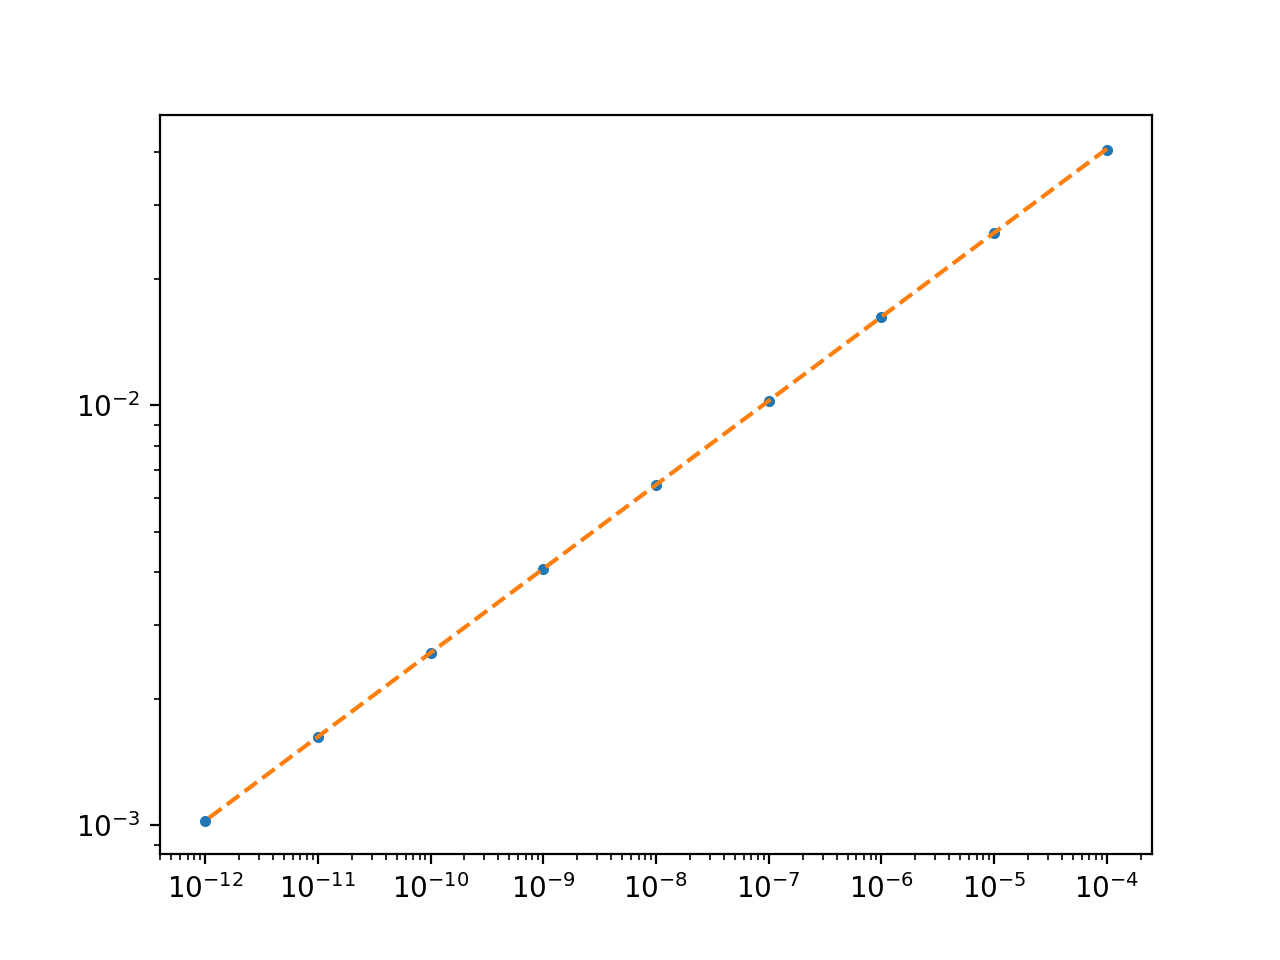

In [151]:
# Validate that local error goes like dt^5
plt.figure()
plt.loglog(tols,dts,'.')
plt.loglog(tols,(tols/tols[-1])**(1/5)*dts[-1],'--')
print('slope = ', )

## Global error as a function of time

6.72073284636e-10


<IPython.core.display.Javascript object>


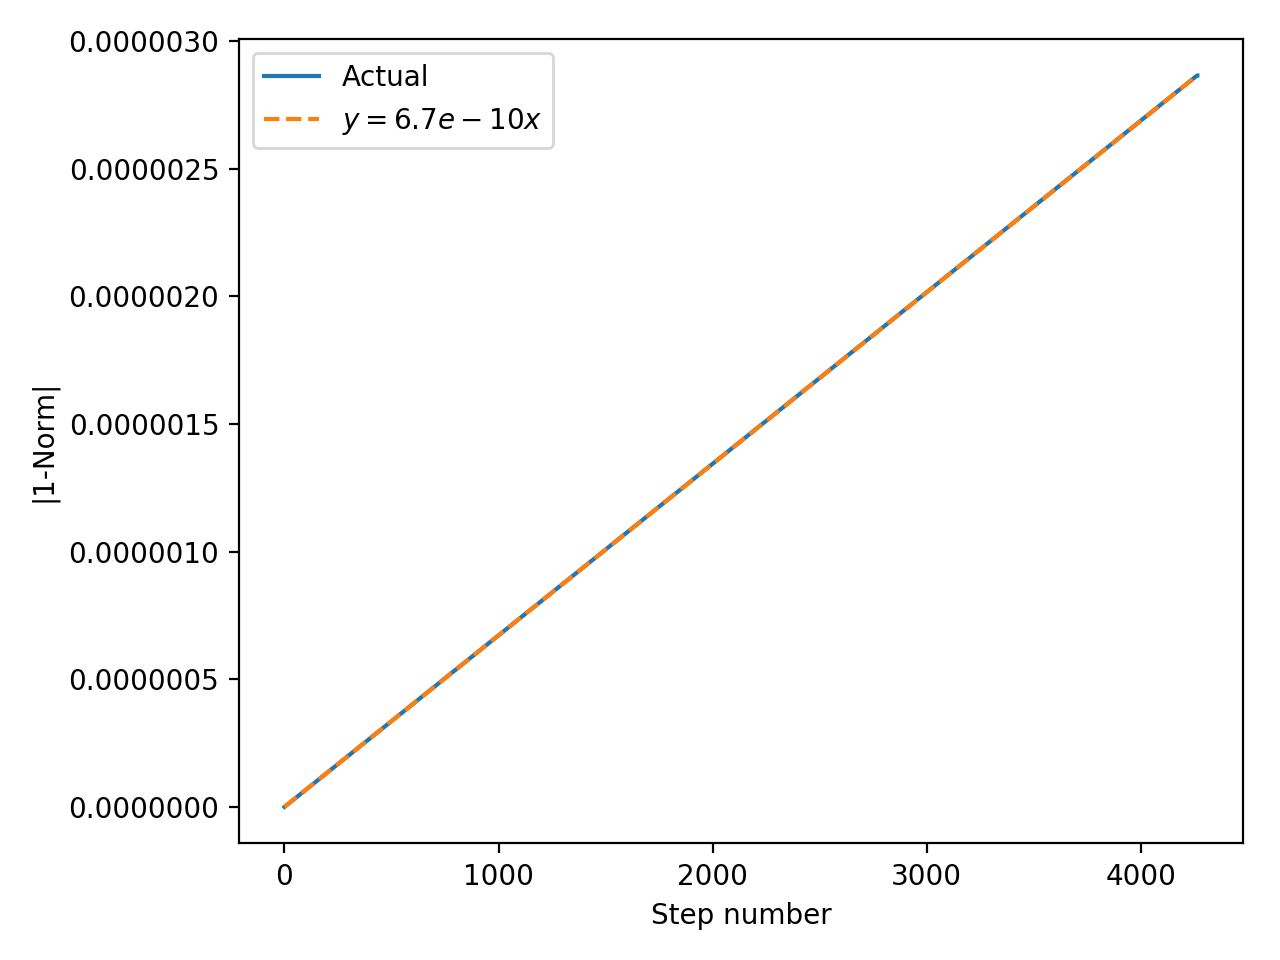

In [180]:
rk.plot_norm()
plt.tight_layout()

<IPython.core.display.Javascript object>


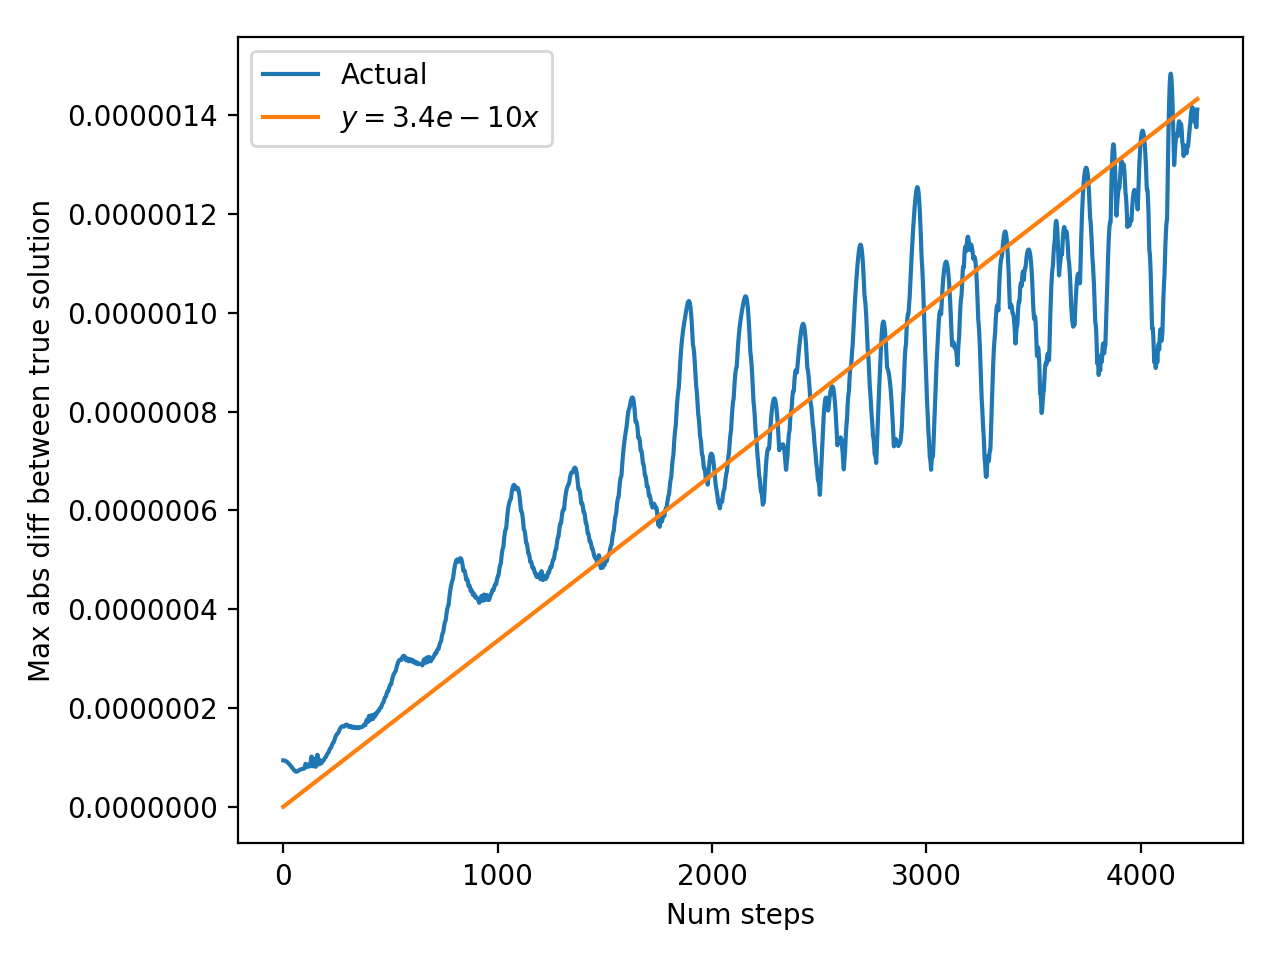

In [195]:
rk.plot_max_diff(rel=False)
plt.tight_layout()

<IPython.core.display.Javascript object>


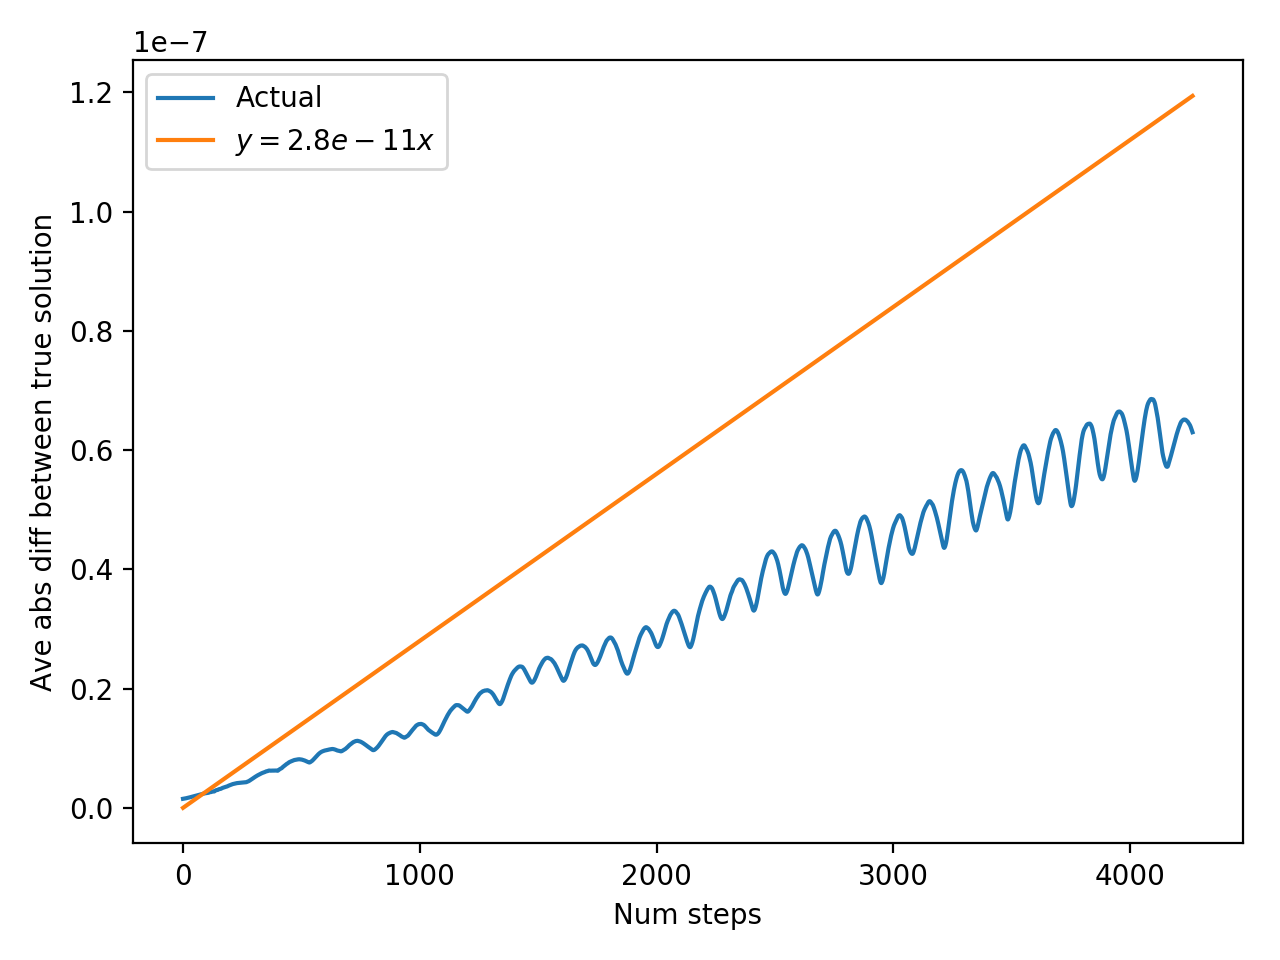

In [194]:
rk.plot_mean_diff(rel=False)
plt.tight_layout()

278228 46183 0.001784545235


<IPython.core.display.Javascript object>


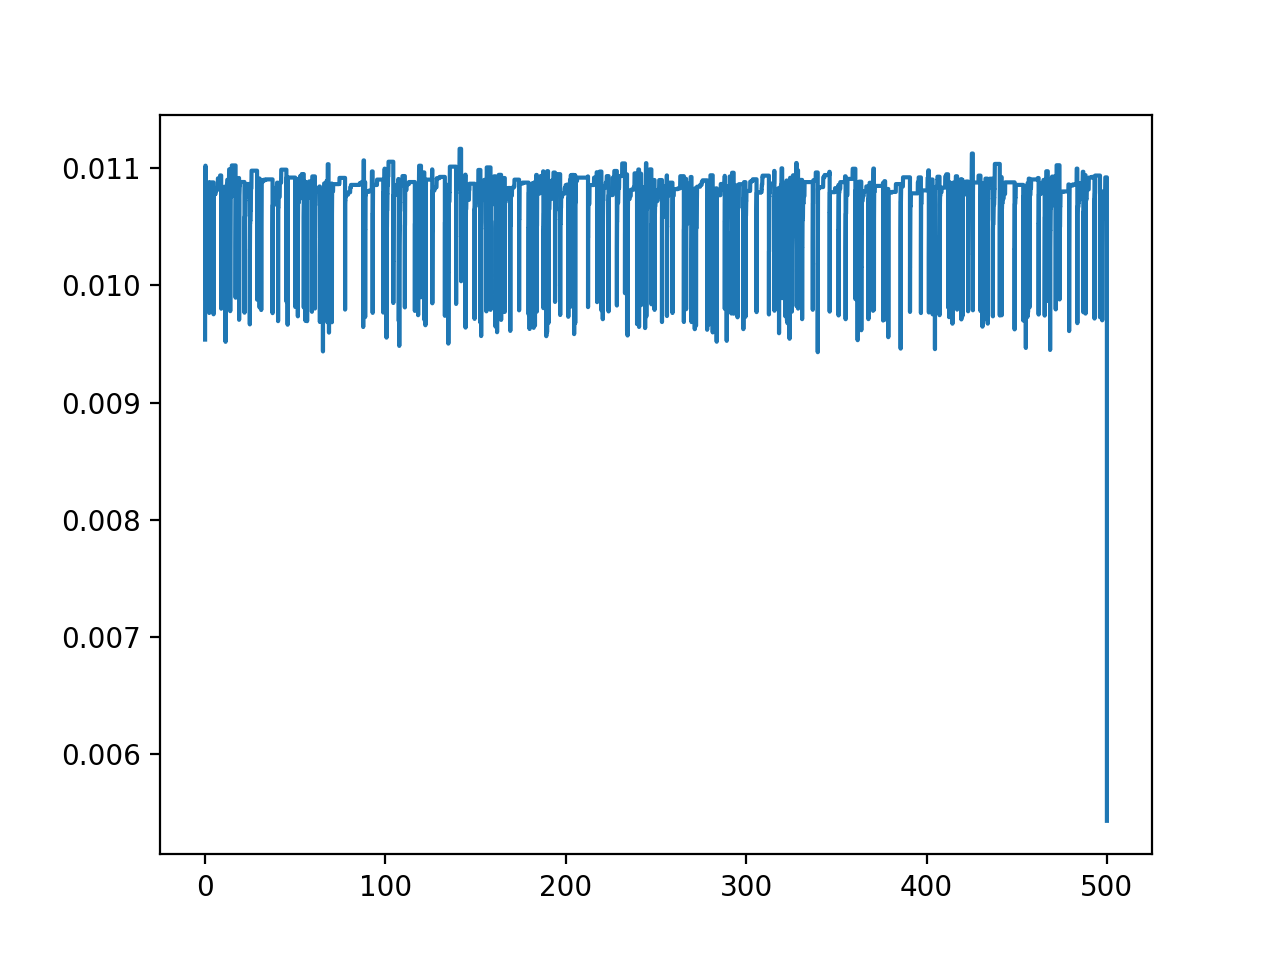

In [23]:
rk.set_H(truncation_size=20)
fun = rk.dH0
tfinal = 500
rk45 = RK45(rk.dH1,0,rk.psi1r,tfinal,atol=1E-9,rtol=1E-6)
times = []
states = []
while rk45.t < tfinal:
    rk45.step()
    times.append(rk45.t)
    states.append(rk45.y)
np_states = np.zeros((states[0].size,len(states)),dtype='complex')
for i in range(len(states)):
    np_states[:,i] = states[i]
print(rk45.nfev,len(times),np.abs(1-np.sum(np.abs(states[-1])**2)))
plt.figure()
plt.plot(times[1:],np.diff(times))

## dt as a function of N

In [197]:
trunc_sizes

array([  10.        ,   12.91549665,   16.68100537,   21.5443469 ,
         27.82559402,   35.93813664,   46.41588834,   59.94842503,
         77.42636827,  100.        ])

<IPython.core.display.Javascript object>


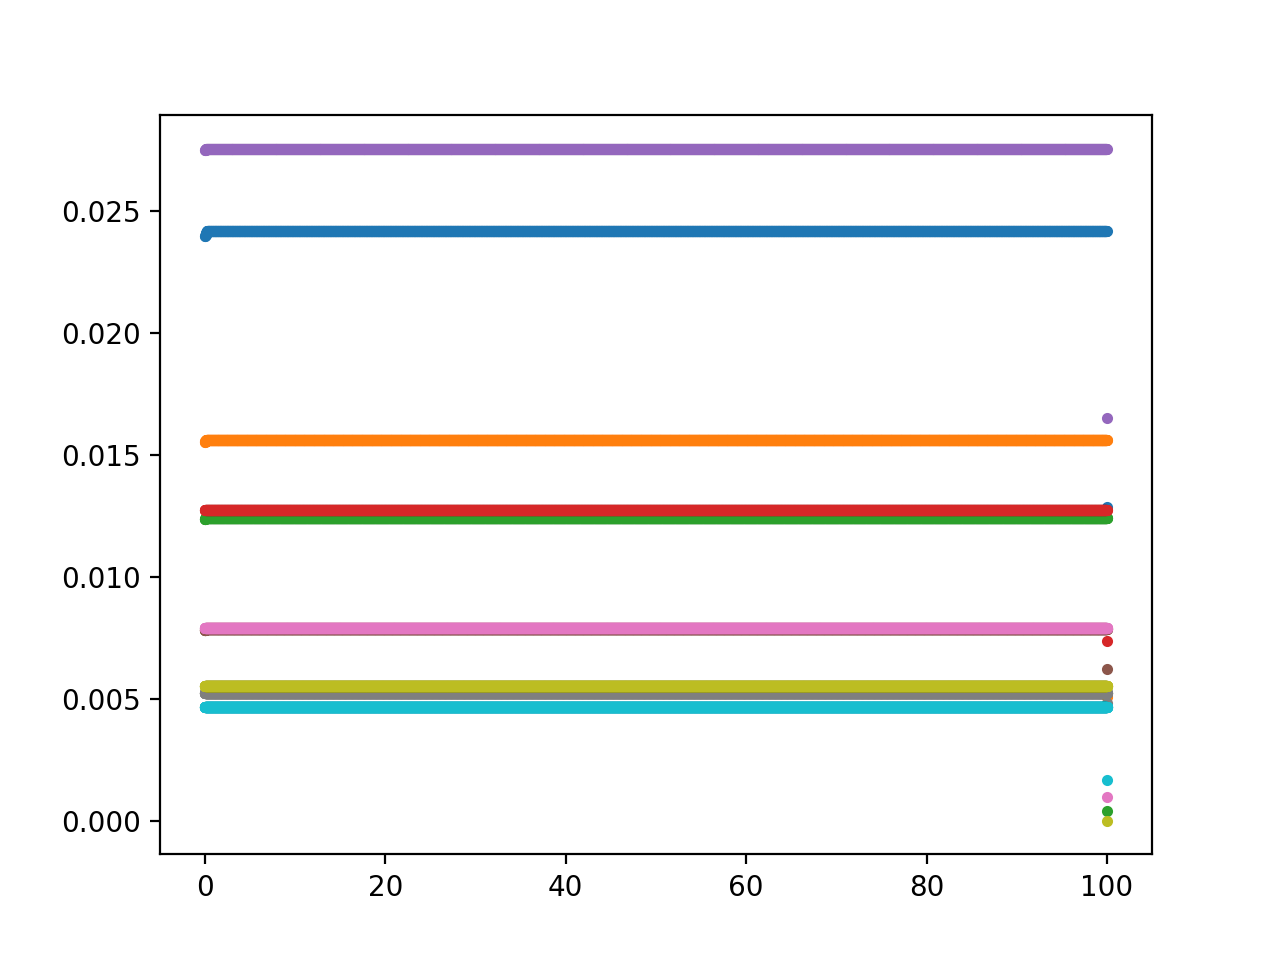

In [100]:
tfinal = 100
trunc_sizes = np.sqrt(np.logspace(2,4,num=10))
act_sizes = np.zeros(trunc_sizes.size)
nfevs = np.zeros(trunc_sizes.size)
nfevsr = np.zeros(trunc_sizes.size)
all_times = []
all_timesr = []
plt.figure()
for i in range(trunc_sizes.size):
    rk.set_H(truncation_size=int(trunc_sizes[i]))
    act_sizes[i] = rk.H1.shape[0]
    rk45 = RK45(rk.dH1,0,rk.psi1,tfinal,atol=1E-8,rtol=1E-8)
    rk45r = RK45(rk.dH1,0,rk.psi1r,tfinal,atol=1E-8,rtol=1E-8)
    times = []
    while rk45.t < tfinal:
        rk45.step()
        times.append(rk45.t)
    timesr = []
    while rk45r.t < tfinal:
        rk45r.step()
        timesr.append(rk45r.t)
    nfevs[i] = rk45.nfev
    nfevsr[i] = rk45r.nfev
    all_times.append(copy.deepcopy(times))
    all_timesr.append(copy.deepcopy(timesr))
    plt.plot(all_times[i][:-1],np.diff(all_times[i]),'.')
    #plt.plot(all_timesr[i][:-1],np.diff(all_timesr[i]),'-')

<IPython.core.display.Javascript object>


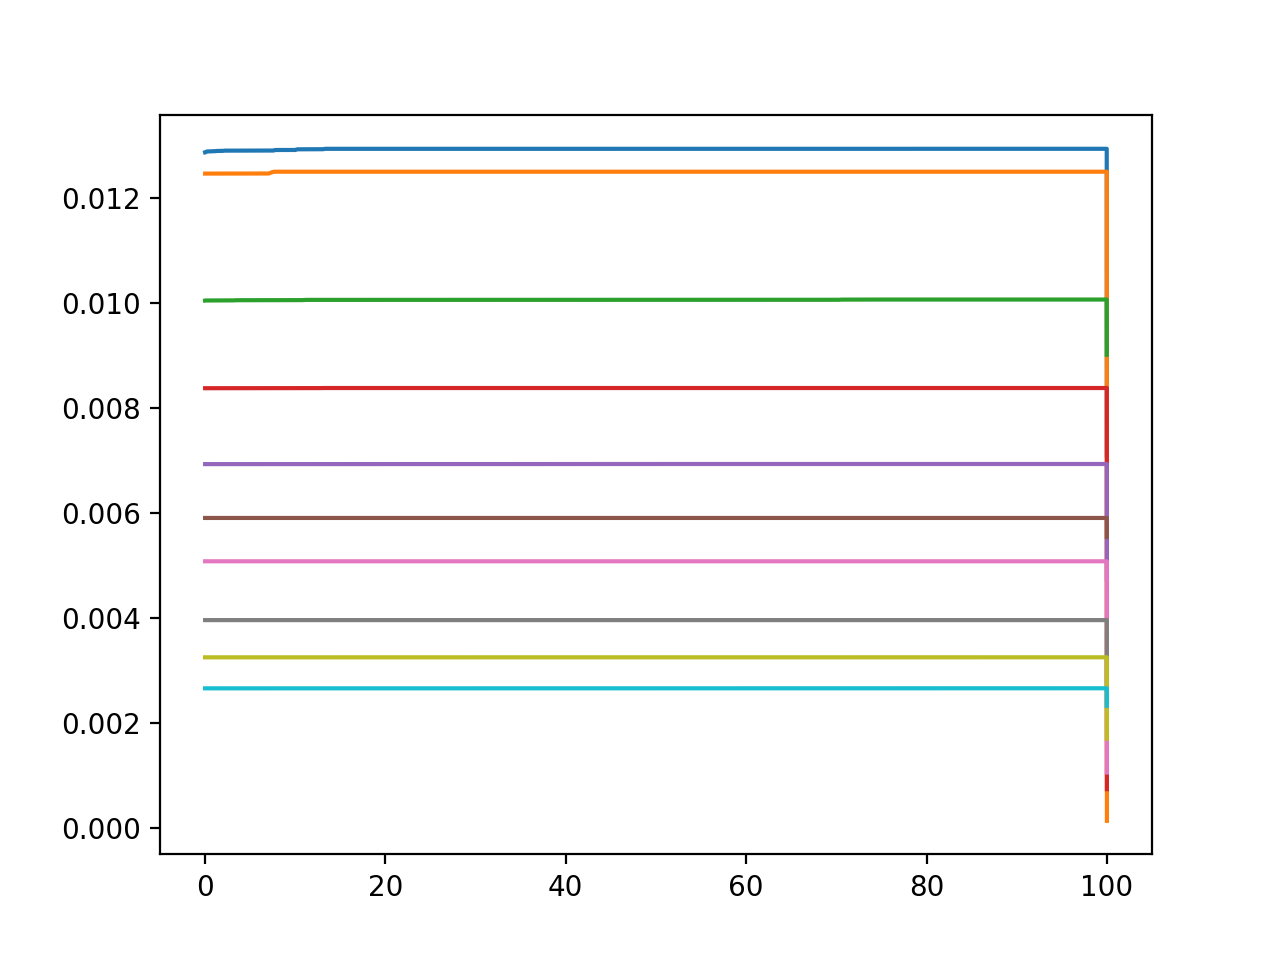

In [104]:
plt.figure()
for i in range(trunc_sizes.size):
    #plt.plot(all_times[i][:-1],np.diff(all_times[i]),'.')
    plt.plot(all_timesr[i][:-1],np.diff(all_timesr[i]),'-')

<IPython.core.display.Javascript object>


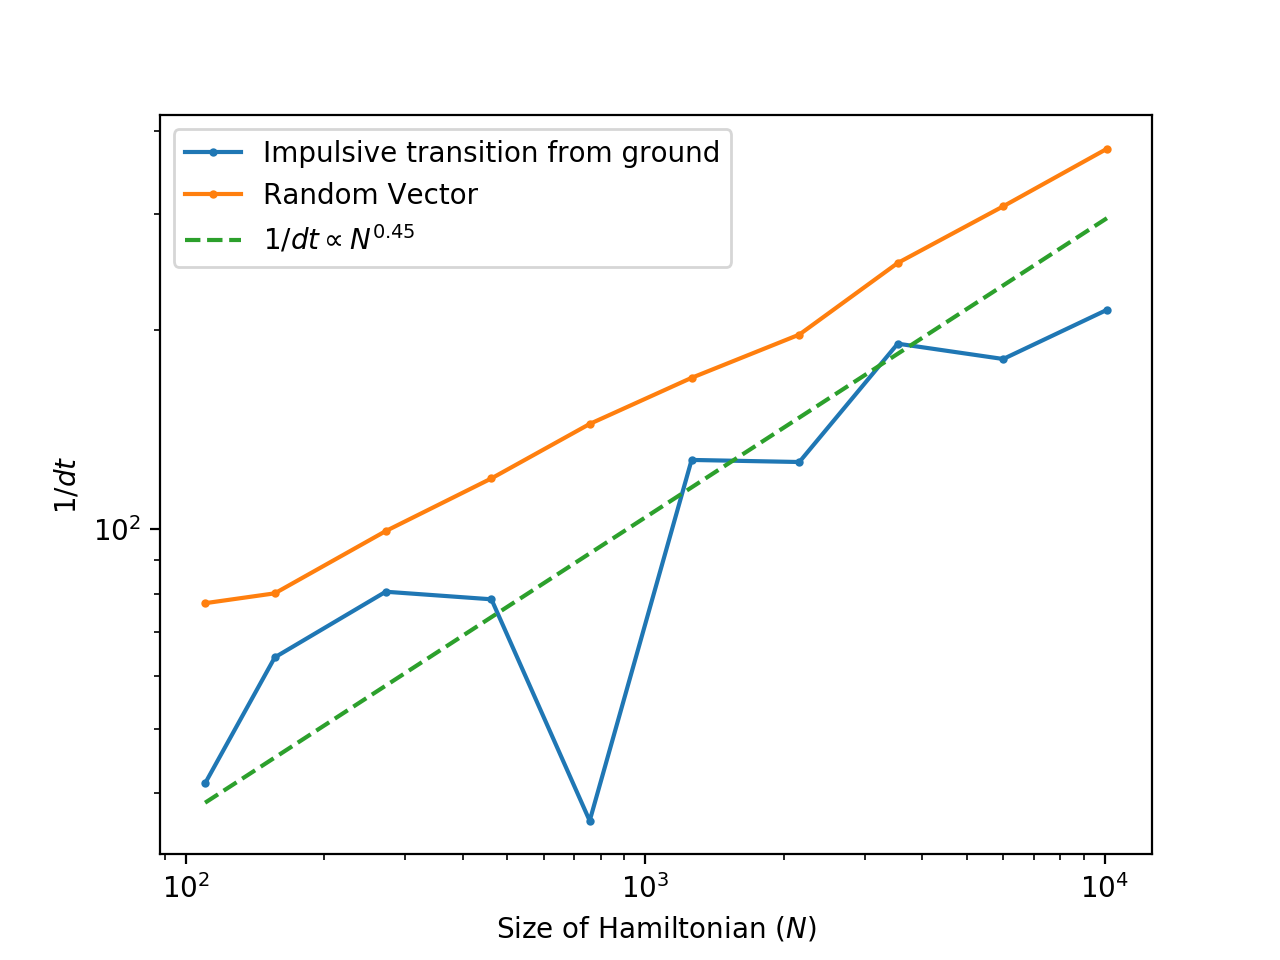

Text(0,0.5,'$1/dt$')

In [101]:
plt.figure()
x = act_sizes
y = np.array([1/np.diff(all_times[i][-3:-1])[0] for i in range(len(trunc_sizes))])
yr = np.array([1/np.diff(all_timesr[i][-3:-1])[0] for i in range(len(trunc_sizes))])
plt.loglog(act_sizes,y,'-o',markersize = 2)
plt.loglog(act_sizes,yr,'-o',markersize = 2)
plt.loglog(act_sizes,(act_sizes/act_sizes[-1])**(0.45)*(y[-1]+yr[-1])/2,'--')
plt.legend(['Impulsive transition from ground','Random Vector','$1/dt\propto N^{0.45}$'])
plt.xlabel('Size of Hamiltonian ($N$)')
plt.ylabel('$1/dt$')

<IPython.core.display.Javascript object>


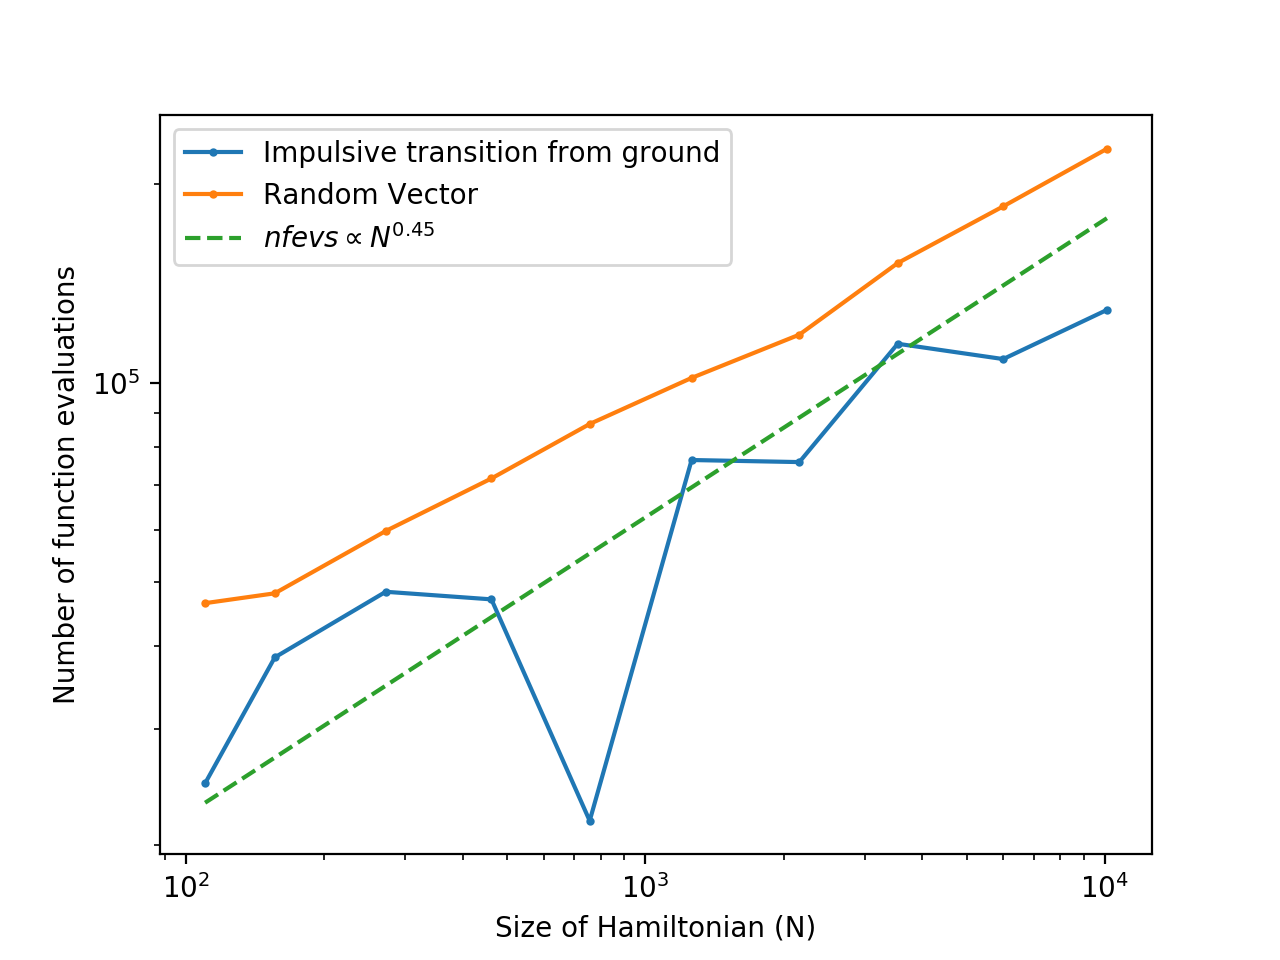

Text(0,0.5,'Number of function evaluations')

In [102]:
plt.figure()
x = act_sizes
y = nfevs
yr = nfevsr
plt.loglog(x,y,'-o',markersize = 2)
plt.loglog(x,yr,'-o',markersize = 2)
plt.loglog(act_sizes,(act_sizes/act_sizes[-1])**(0.45)*(y[-1]+yr[-1])/2,'--')
plt.legend(['Impulsive transition from ground','Random Vector','$nfevs\propto N^{0.45}$'])
plt.xlabel('Size of Hamiltonian (N)')
plt.ylabel('Number of function evaluations')

## Decay of vibrational overlaps

<IPython.core.display.Javascript object>


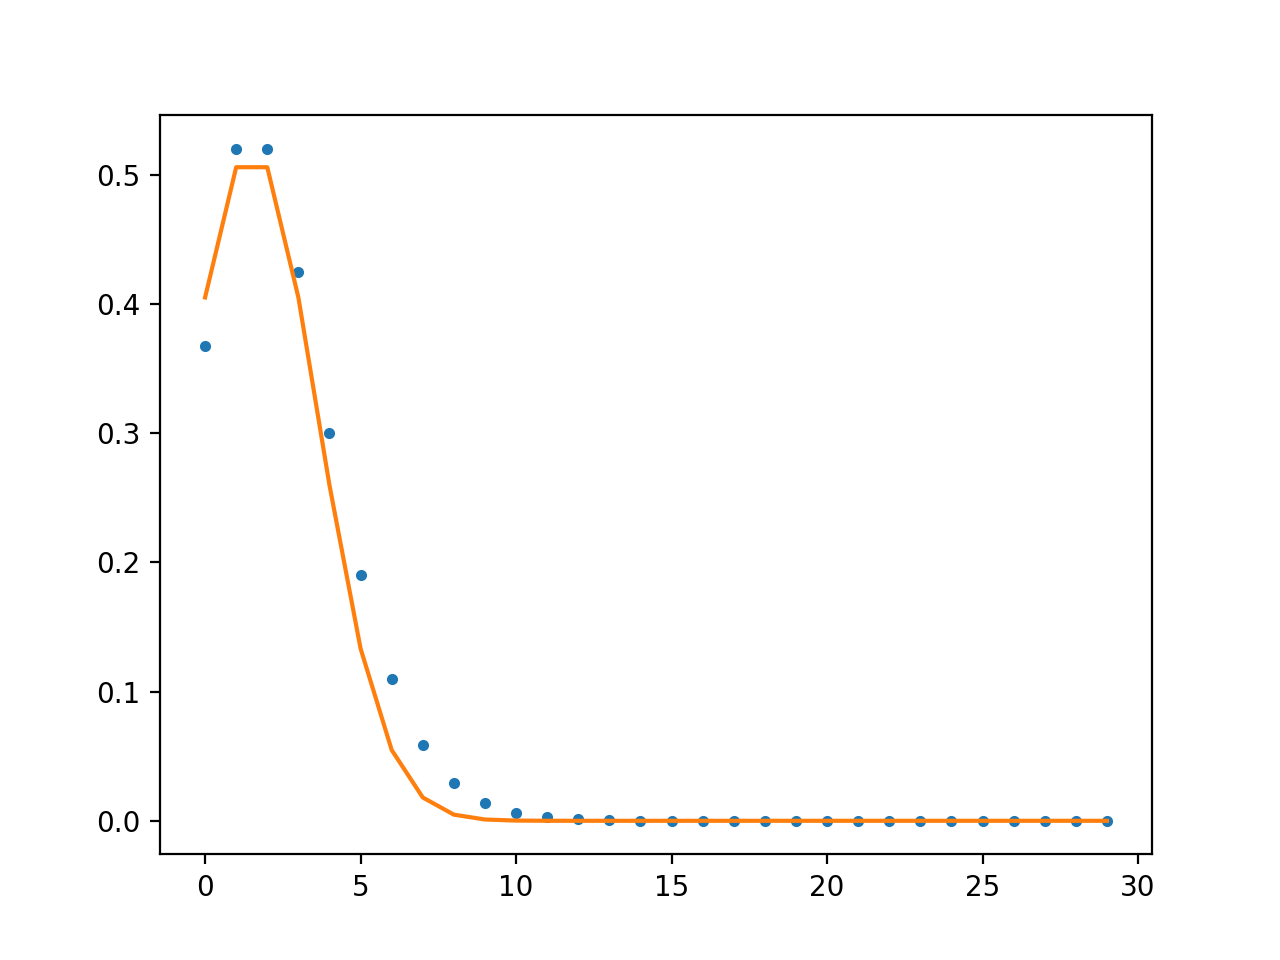

In [134]:
plt.figure()
S = 2
x = np.arange(30)
y = np.exp(-S/2)*S**(x/2)*np.sqrt(1/scipy.special.factorial(x))
plt.plot(x,y,'.')
plt.plot(x,np.exp(-(x-S+0.5)**2/(2*(S+2.5)))*np.max(y))

## Dipole overlap convergence with N

### RK45

In [140]:
tfinal = 30
trunc_sizes = np.sqrt(np.logspace(2,4,num=10))
#trunc_sizes = np.arange(5,50,5)
act_sizes = np.zeros(trunc_sizes.size,dtype='int')
psi_finals1 = []
psi_finals2 = []
psi_finals3 = []
psi_finals4 = []
psi_finals5 = []
psi_finals6 = []
psi_finals7 = []
N_max = int(trunc_sizes[-1])
for i in range(trunc_sizes.size):
    rk.set_H(truncation_size=int(trunc_sizes[i]))
    act_sizes[i] = rk.H1.shape[0]
    rk.RKU(rk.psi1,0,tfinal,manifold_num = 1,atol=1E-7,rtol=1E-7)
    new_states = rk.convert_states(rk.states[:,-2:],manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,N_max)
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    psi_finals1.append(padded_vec_states[:,-1])
    
    rk.RKU(rk.psi1,0,tfinal,manifold_num = 1,atol=1E-8,rtol=1E-8)
    new_states = rk.convert_states(rk.states[:,-2:],manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,N_max)
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    psi_finals2.append(padded_vec_states[:,-1])
    
    rk.RKU(rk.psi1,0,tfinal,manifold_num = 1,atol=1E-9,rtol=1E-9)
    new_states = rk.convert_states(rk.states[:,-2:],manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,N_max)
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    psi_finals3.append(padded_vec_states[:,-1])
    
    rk.RKU(rk.psi1,0,tfinal,manifold_num = 1,atol=1E-10,rtol=1E-10)
    new_states = rk.convert_states(rk.states[:,-2:],manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,N_max)
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    psi_finals4.append(padded_vec_states[:,-1])
    
    rk.RKU(rk.psi1,0,tfinal,manifold_num = 1,atol=1E-11,rtol=1E-11)
    new_states = rk.convert_states(rk.states[:,-2:],manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,N_max)
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    psi_finals5.append(padded_vec_states[:,-1])
    
    rk.RKU(rk.psi1,0,tfinal,manifold_num = 1,atol=1E-12,rtol=1E-12)
    new_states = rk.convert_states(rk.states[:,-2:],manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,N_max)
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    psi_finals6.append(padded_vec_states[:,-1])
    t0 = time.clock()
    print(t0)
    rk.RKU(rk.psi1,0,tfinal,manifold_num = 1,atol=1E-13,rtol=1E-13)
    new_states = rk.convert_states(rk.states[:,-2:],manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,N_max)
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    psi_finals7.append(padded_vec_states[:,-1])
    print(time.clock() - t0)
    
psi_finals_arr1 = np.zeros((trunc_sizes.size,psi_finals1[-1].size),dtype='complex')
psi_finals_arr2 = np.zeros((trunc_sizes.size,psi_finals2[-1].size),dtype='complex')
psi_finals_arr3 = np.zeros((trunc_sizes.size,psi_finals3[-1].size),dtype='complex')
psi_finals_arr4 = np.zeros((trunc_sizes.size,psi_finals4[-1].size),dtype='complex')
psi_finals_arr5 = np.zeros((trunc_sizes.size,psi_finals5[-1].size),dtype='complex')
psi_finals_arr6 = np.zeros((trunc_sizes.size,psi_finals6[-1].size),dtype='complex')
psi_finals_arr7 = np.zeros((trunc_sizes.size,psi_finals7[-1].size),dtype='complex')
for i in range(trunc_sizes.size):
    psi_finals_arr1[i,:] = psi_finals1[i]
    psi_finals_arr2[i,:] = psi_finals2[i]
    psi_finals_arr3[i,:] = psi_finals3[i]
    psi_finals_arr4[i,:] = psi_finals4[i]
    psi_finals_arr5[i,:] = psi_finals5[i]
    psi_finals_arr6[i,:] = psi_finals6[i]
    psi_finals_arr7[i,:] = psi_finals7[i]

2379.107922
1.6145489999998972
2383.289898
1.6243620000000192
2388.363929
2.018130999999812
2393.549622
1.9713959999999133
2399.300109
2.3269050000003517
2406.328058
3.0298689999999624
2419.579031
5.853947999999946
2441.135142
7.811597999999776
2475.151567
12.08584800000017
2537.681817
19.12927499999978


In [71]:
trunc_sizes2 = np.zeros(trunc_sizes.shape,dtype='int')
trunc_sizes2[:] = trunc_sizes

In [299]:
act_sizes

array([  30,  110,  240,  420,  650,  930, 1260, 1640, 2070, 2550, 3080,
       3660, 4290, 4970, 5700, 6480, 7310, 8190, 9120])

<IPython.core.display.Javascript object>


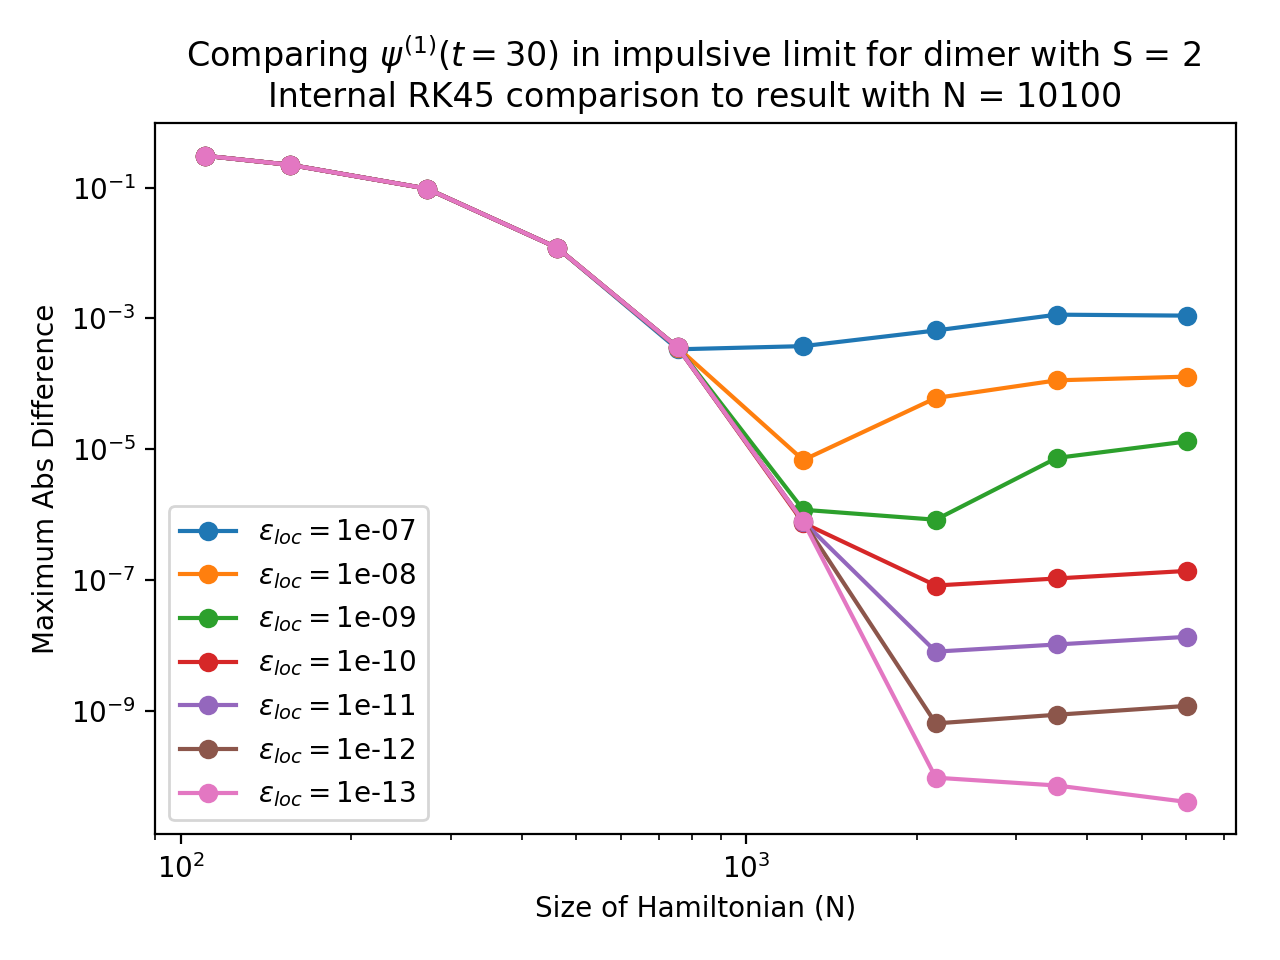

<IPython.core.display.Javascript object>


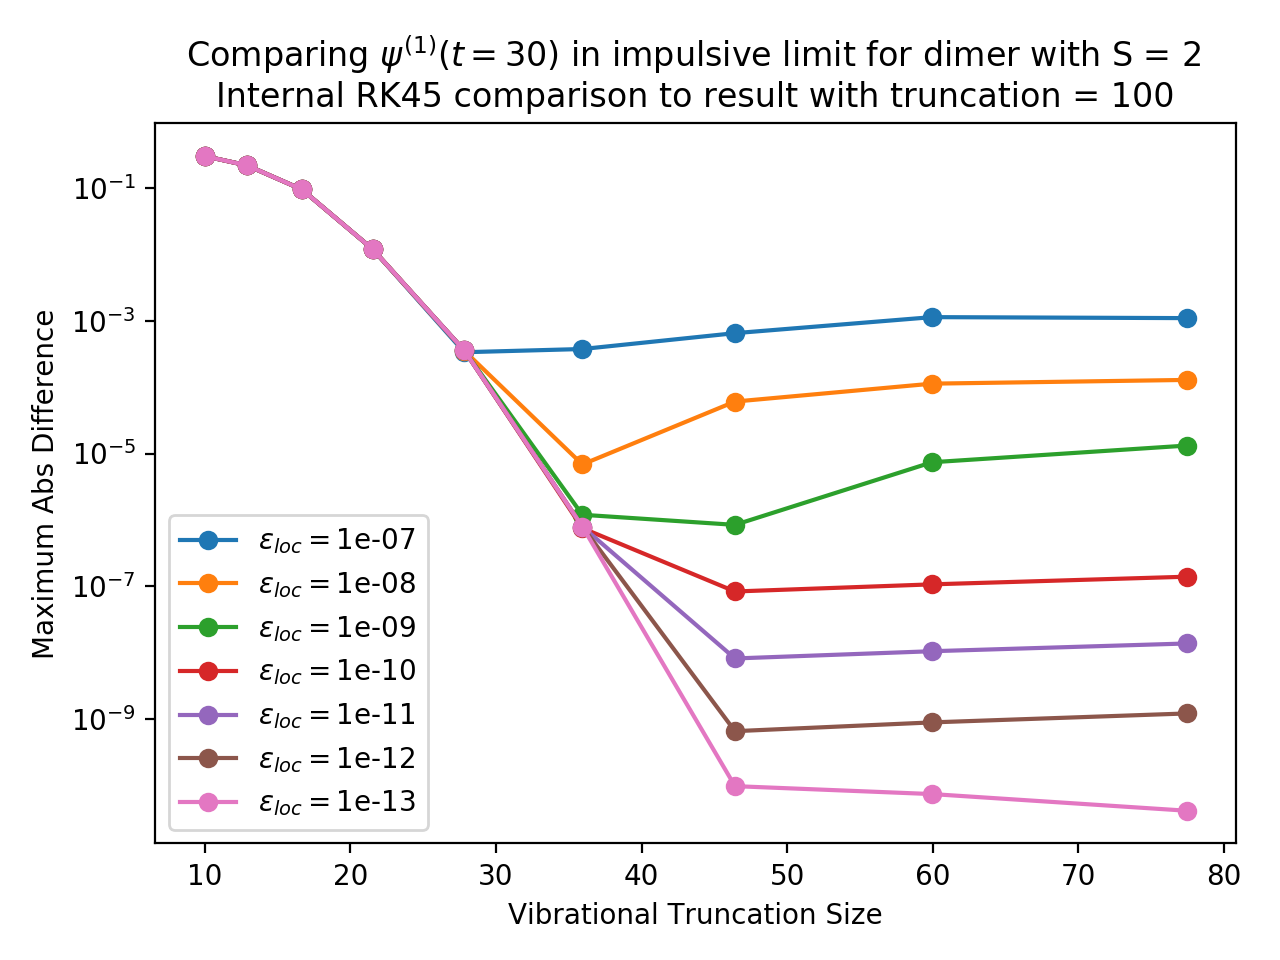

In [141]:
epsilons = np.logspace(-7,-13,num=7)
q = -1
y1 = psi_finals_arr1[:q,:] - psi_finals_arr7[q,:]
y2 = psi_finals_arr2[:q,:] - psi_finals_arr7[q,:]
y3 = psi_finals_arr3[:q,:] - psi_finals_arr7[q,:]
y4 = psi_finals_arr4[:q,:] - psi_finals_arr7[q,:]
y5 = psi_finals_arr5[:q,:] - psi_finals_arr7[q,:]
y6 = psi_finals_arr6[:q,:] - psi_finals_arr7[q,:]
y7 = psi_finals_arr7[:q,:] - psi_finals_arr7[q,:]
#y = np.mean(np.abs(y),axis=1)
y1 = np.max(np.abs(y1),axis=1)
y2 = np.max(np.abs(y2),axis=1)
y3 = np.max(np.abs(y3),axis=1)
y4 = np.max(np.abs(y4),axis=1)
y5 = np.max(np.abs(y5),axis=1)
y6 = np.max(np.abs(y6),axis=1)
y7 = np.max(np.abs(y7),axis=1)
#y = np.abs(y[:,10])
x = act_sizes[:q]
x2 = trunc_sizes[:q]
fig, ax = plt.subplots()
ax.loglog(x,y1,'-o')
ax.loglog(x,y2,'-o')
ax.loglog(x,y3,'-o')
ax.loglog(x,y4,'-o')
ax.loglog(x,y5,'-o')
ax.loglog(x,y6,'-o')
ax.loglog(x,y7,'-o')
plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
         'Internal RK45 comparison to result with N = {}'.format(int(act_sizes[-1])))
plt.legend([r'$\epsilon_{loc}=$'+'{:.0e}'.format(epsilon) for epsilon in epsilons])
ax.set_ylabel('Maximum Abs Difference')
ax.set_xlabel('Size of Hamiltonian (N)')
plt.tight_layout()

fig, ax = plt.subplots()
ax.semilogy(x2,y1,'-o')
ax.semilogy(x2,y2,'-o')
ax.semilogy(x2,y3,'-o')
ax.semilogy(x2,y4,'-o')
ax.semilogy(x2,y5,'-o')
ax.semilogy(x2,y6,'-o')
ax.semilogy(x2,y7,'-o')
plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
         'Internal RK45 comparison to result with truncation = {}'.format(int(trunc_sizes[-1])))
plt.legend([r'$\epsilon_{loc}=$'+'{:.0e}'.format(epsilon) for epsilon in epsilons])
ax.set_ylabel('Maximum Abs Difference')
ax.set_xlabel('Vibrational Truncation Size')
plt.tight_layout()

In [60]:
np.sum(np.abs(psi_finals_arr4[-1,:]**2))

0.99999991064732607

In [290]:
rk.H0.shape[0]

4560

<IPython.core.display.Javascript object>


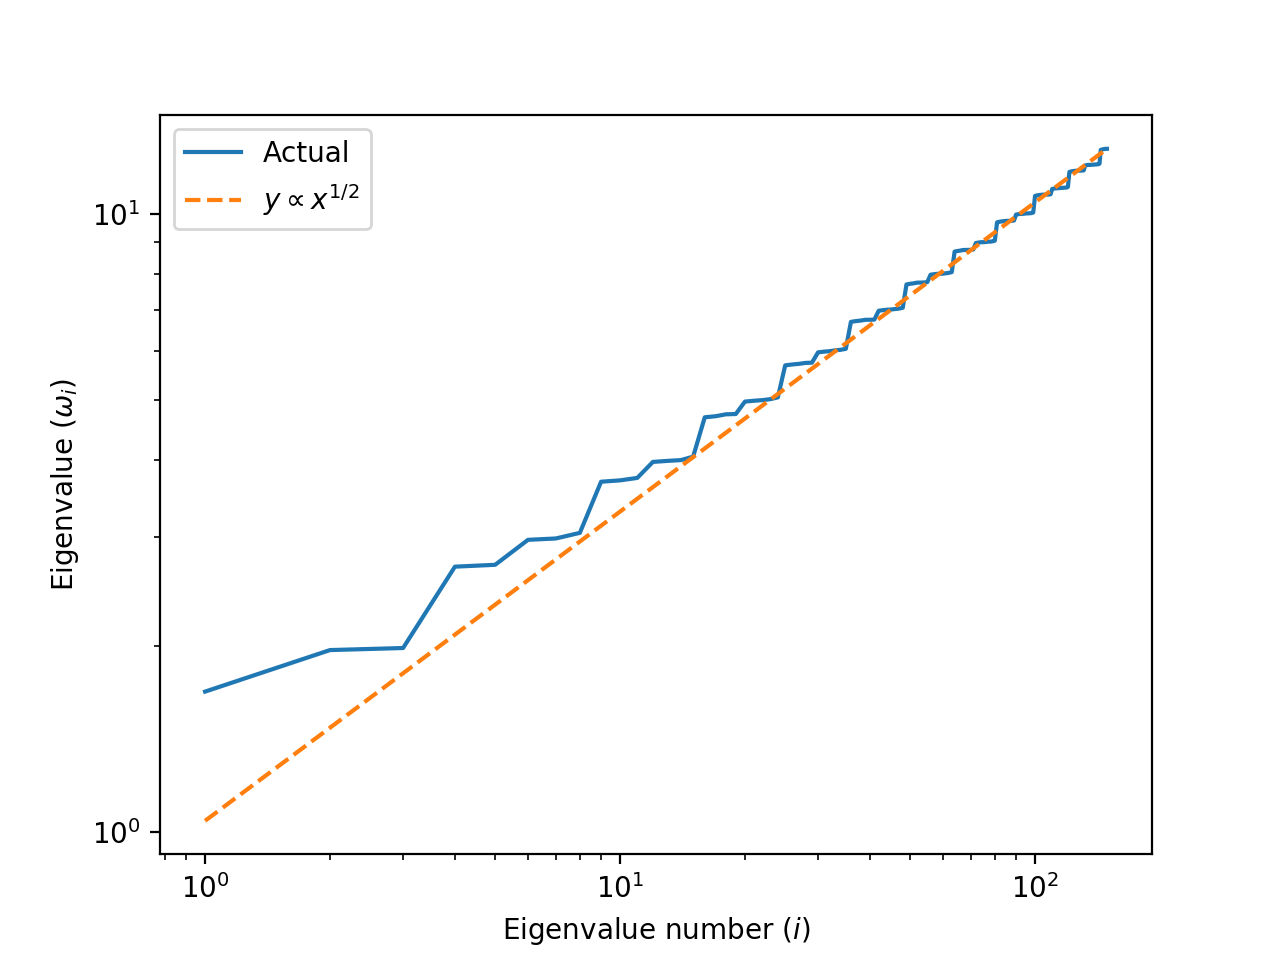

Text(0,0.5,'Eigenvalue ($\\omega_i$)')

In [298]:
plt.figure()
y = rk.eigenvalues[1][1:]
x = np.arange(1,y.size+1)
plt.loglog(x,y)
plt.loglog(x,(x/x[-1])**(1/2)*y[-1],'--')
plt.legend(['Actual','$y\propto x^{1/2}$'])
plt.xlabel('Eigenvalue number ($i$)')
plt.ylabel('Eigenvalue ($\omega_i$)')

### Full Eigensystem

In [135]:
tfinal = 30
#trunc_sizes = np.sqrt(np.logspace(2,4,num=10))
#trunc_sizes = np.arange(10,80,10)
trunc_sizes = np.sqrt(np.logspace(2,4,num=10))
act_sizes = np.zeros(trunc_sizes.size,dtype='int')
full_psi_finals = []
N_max = int(trunc_sizes[-1])
for i in range(trunc_sizes.size):
    rk.set_H(truncation_size=int(trunc_sizes[i]))
    act_sizes[i] = rk.H1.shape[0]
    rk.set_full_eigensystem()
    rk.full_exact_U(rk.psi1,manifold_num = 1,t=np.array([0,tfinal]))
    new_states = rk.convert_states(rk.full_exact_states,manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,N_max)
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    full_psi_finals.append(padded_vec_states[:,-1])
    
full_psi_finals_arr = np.zeros((trunc_sizes.size,full_psi_finals[-1].size),dtype='complex')
for i in range(trunc_sizes.size):
    full_psi_finals_arr[i,:] = full_psi_finals[i]

<IPython.core.display.Javascript object>


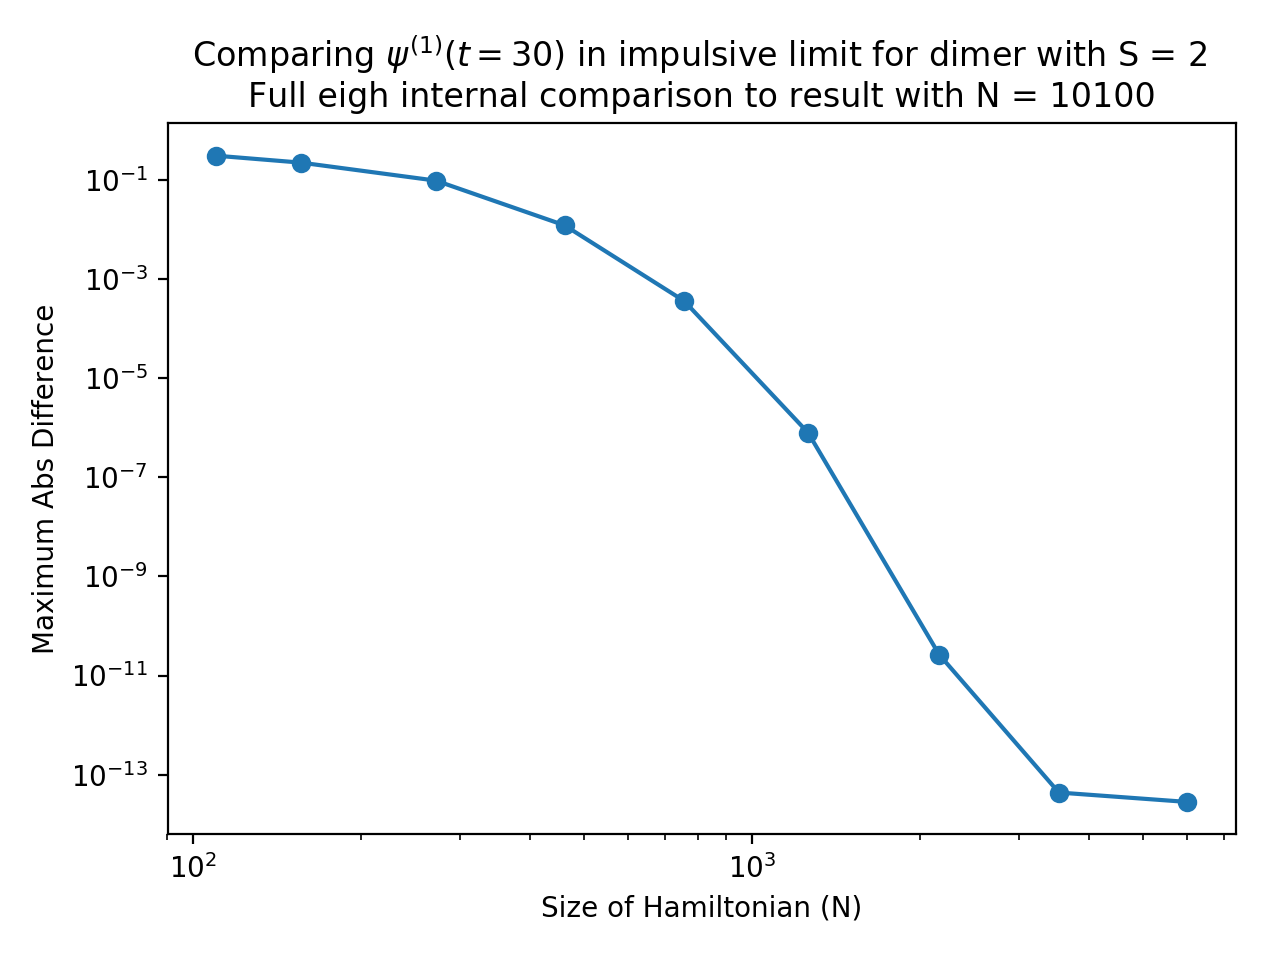

<IPython.core.display.Javascript object>


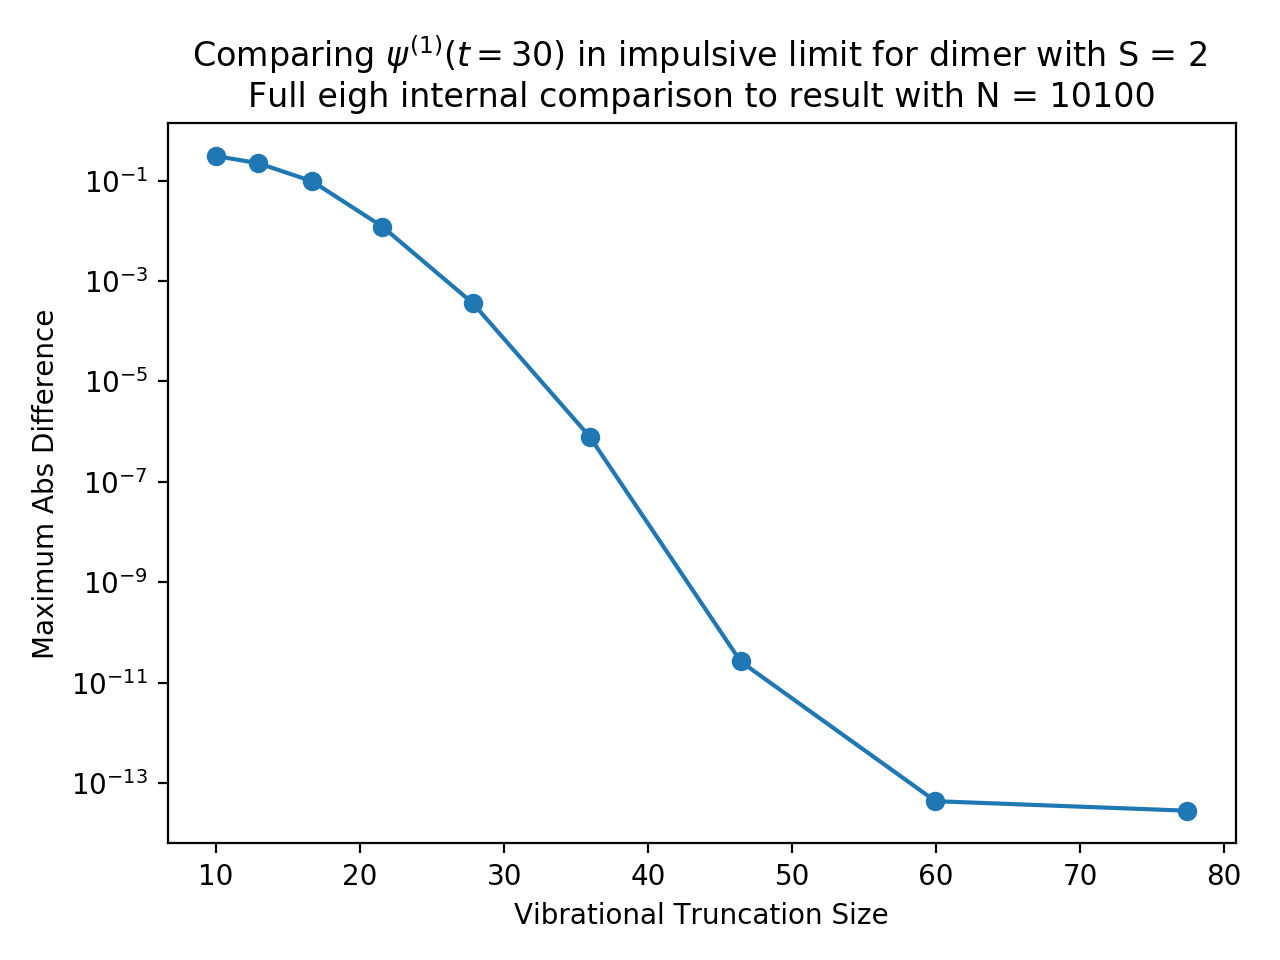

In [136]:
q = -1
y = full_psi_finals_arr[:q,:] - full_psi_finals_arr[q,:]
#y = np.mean(np.abs(y),axis=1)
y = np.max(np.abs(y),axis=1)
#y = np.abs(y[:,10])
x = act_sizes[:q]
x2 = trunc_sizes[:q]
fig, ax = plt.subplots()
ax.loglog(x,y,'-o')
plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
         'Full eigh internal comparison to result with N = {}'.format(int(act_sizes[-1])))
ax.set_ylabel('Maximum Abs Difference')
ax.set_xlabel('Size of Hamiltonian (N)')
plt.tight_layout()

fig, ax = plt.subplots()
ax.semilogy(x2,y,'-o')
plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
         'Full eigh internal comparison to result with N = {}'.format(int(act_sizes[-1])))
ax.set_ylabel('Maximum Abs Difference')
ax.set_xlabel('Vibrational Truncation Size')
plt.tight_layout()

### Part of Full Eigensystem

In [3]:
def f(occ_num,num_vibrations):
    ans = 0
    for i in range(occ_num):
        ans += scipy.special.binom(num_vibrations+i-1,i)
    return ans

In [58]:
max_occ_num = np.arange(10,20,dtype='int')
trunc_sizes = max_occ_num*3
num_eigvals = np.array([int(f(n,2)) for n in max_occ_num])
#num_eigvals = np.arange(1,200,1)
tfinal = 30
irl_psi_finals = []
for i in range(num_eigvals.size):
    rk.set_H(truncation_size=trunc_sizes[i])
    act_size = rk.H1.shape[0]
    rk.set_full_eigensystem()
    rk.truncate_full_eigensystem(num_eigvals[i])
    rk.exact_U(rk.psi1,manifold_num = 1,t=np.array([0,tfinal]))
    new_states = rk.convert_states(rk.exact_states,manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,trunc_sizes[-1])
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    irl_psi_finals.append(padded_vec_states[:,-1])
    #irl_psi_finals.append(rk.exact_states[:,-1])
    
irl_psi_finals_arr = np.zeros((num_eigvals.size,irl_psi_finals[-1].size),dtype='complex')
for i in range(num_eigvals.size):
    irl_psi_finals_arr[i,:] = irl_psi_finals[i]

<IPython.core.display.Javascript object>


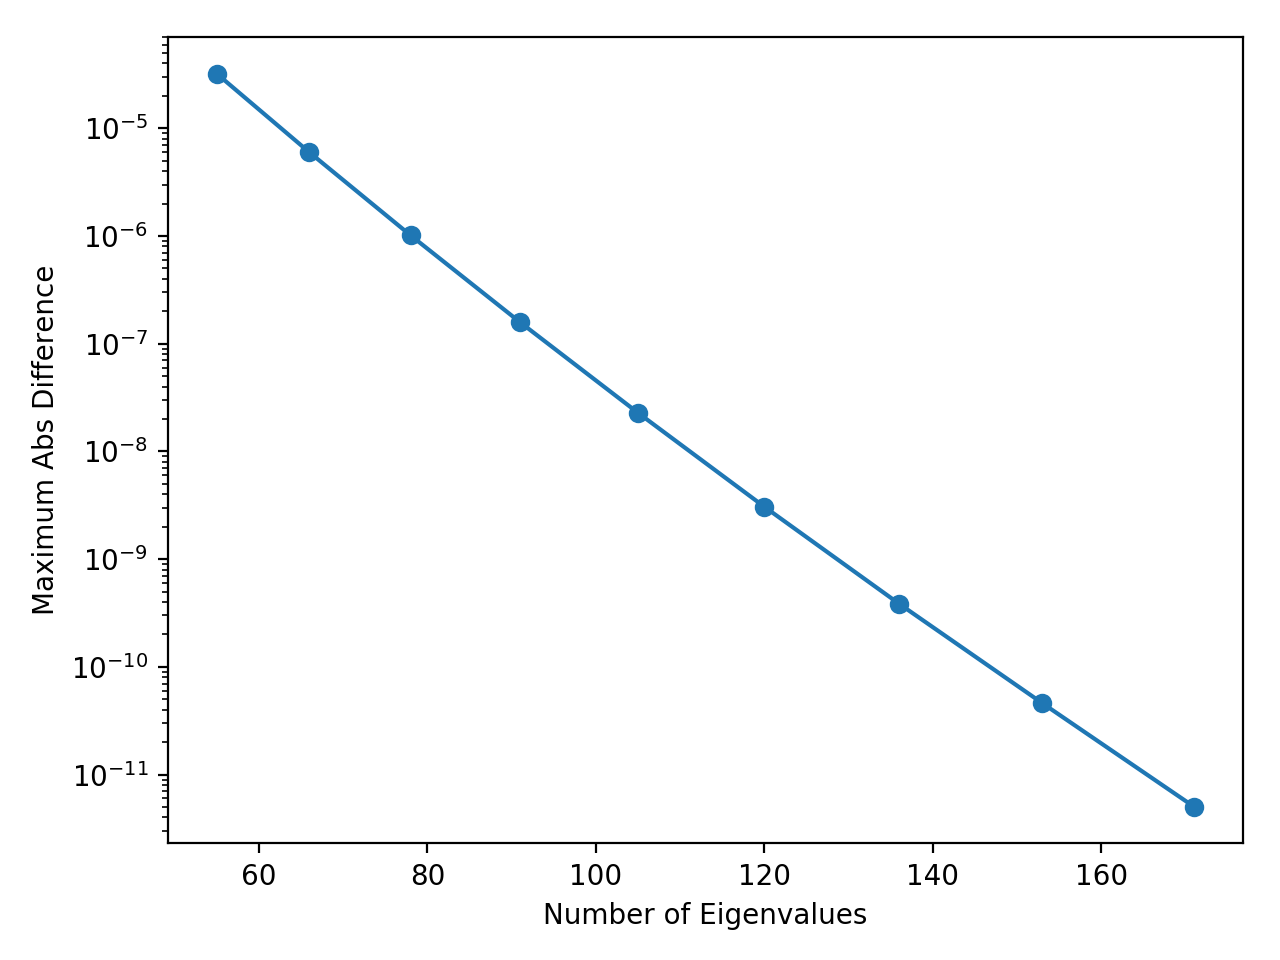

In [59]:
q = -1
y = irl_psi_finals_arr[:q,:] - irl_psi_finals_arr[q,:]
#y = np.mean(np.abs(y),axis=1)
#y = np.max(np.abs(y),axis=1)
y = np.abs(y[:,0])
x = num_eigvals[:q]
#x2 = trunc_sizes[:q]
fig, ax = plt.subplots()
ax.semilogy(x,y,'-o')
#plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
#         'Full eigh comparison to result with N = {}'.format(int(act_sizes[-1])))
ax.set_ylabel('Maximum Abs Difference')
ax.set_xlabel('Number of Eigenvalues')
plt.tight_layout()

#fig, ax = plt.subplots()
#ax.semilogy(x2,y,'-o')
#plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
#         'Full eigh comparison to result with N = {}'.format(int(act_sizes[-1])))
#ax.set_ylabel('Maximum Abs Difference')
#ax.set_xlabel('Size of Hamiltonian (N)')
#plt.tight_layout()

### IRL

In [3]:
def f(occ_num,num_vibrations):
    ans = 0
    for i in range(occ_num):
        ans += scipy.special.binom(num_vibrations+i-1,i)
    return ans

In [82]:
import time

In [131]:
max_occ_num = np.arange(4,20,dtype='int')
trunc_sizes = np.array([27,29,31,32,34,36,37,39,40,42,43,45,46,48,49,51])
num_eigvals = np.array([int(f(n,2)) for n in max_occ_num])
act_sizes = np.zeros(trunc_sizes.shape,dtype='int')
tfinal = 30
irl_psi_finals = []
for i in range(num_eigvals.size):
    rk.set_H(truncation_size=trunc_sizes[i])
    act_sizes[i] = rk.H1.shape[0]
    t0 = time.clock()
    rk.set_IRL_eigensystem(num = num_eigvals[i],tol = 0)
    t1 = time.clock()
    rk.set_full_eigensystem()
    t2 = time.clock()
    print(t2-t1,t1-t0)
    rk.exact_U(rk.psi1,manifold_num = 1,t=np.array([0,tfinal]))
    new_states = rk.convert_states(rk.exact_states,manifold_num=1)
    mat_states = rk.vec_to_mat(new_states,manifold_num=1)
    padded_mat_states = rk.zero_pad_mat(mat_states,trunc_sizes[-1])
    padded_vec_states = rk.mat_to_vec(padded_mat_states)
    irl_psi_finals.append(padded_vec_states[:,-1])
    #irl_psi_finals.append(rk.exact_states[:,-1])
    
irl_psi_finals_arr = np.zeros((num_eigvals.size,irl_psi_finals[-1].size),dtype='complex')
for i in range(num_eigvals.size):
    irl_psi_finals_arr[i,:] = irl_psi_finals[i]

0.2832260000000133 0.07408400000008442
0.3733620000000428 0.14114800000015748
0.5364739999999983 0.2162919999998394
0.5833310000000438 0.26117199999998775
0.757904999999937 0.3427910000000338
1.000917999999956 0.5099339999999302
1.1445690000000468 0.6616030000000137
1.4644040000000587 0.8984209999998711
1.4471750000000156 1.2226190000001225
2.212203999999929 1.8523069999998825
2.3269480000001295 2.681284000000005
2.8764220000000478 3.589614999999867
3.6664140000000316 4.878220000000056
4.29076299999997 6.265964000000167
4.739319999999907 8.234216999999944
5.928004000000101 11.047906000000012


In [89]:
print(num_eigvals)
print(trunc_sizes)

[ 55  66  78  91 105 120 136 153 171 190]
[30 33 36 39 42 45 48 51 54 57]


<IPython.core.display.Javascript object>


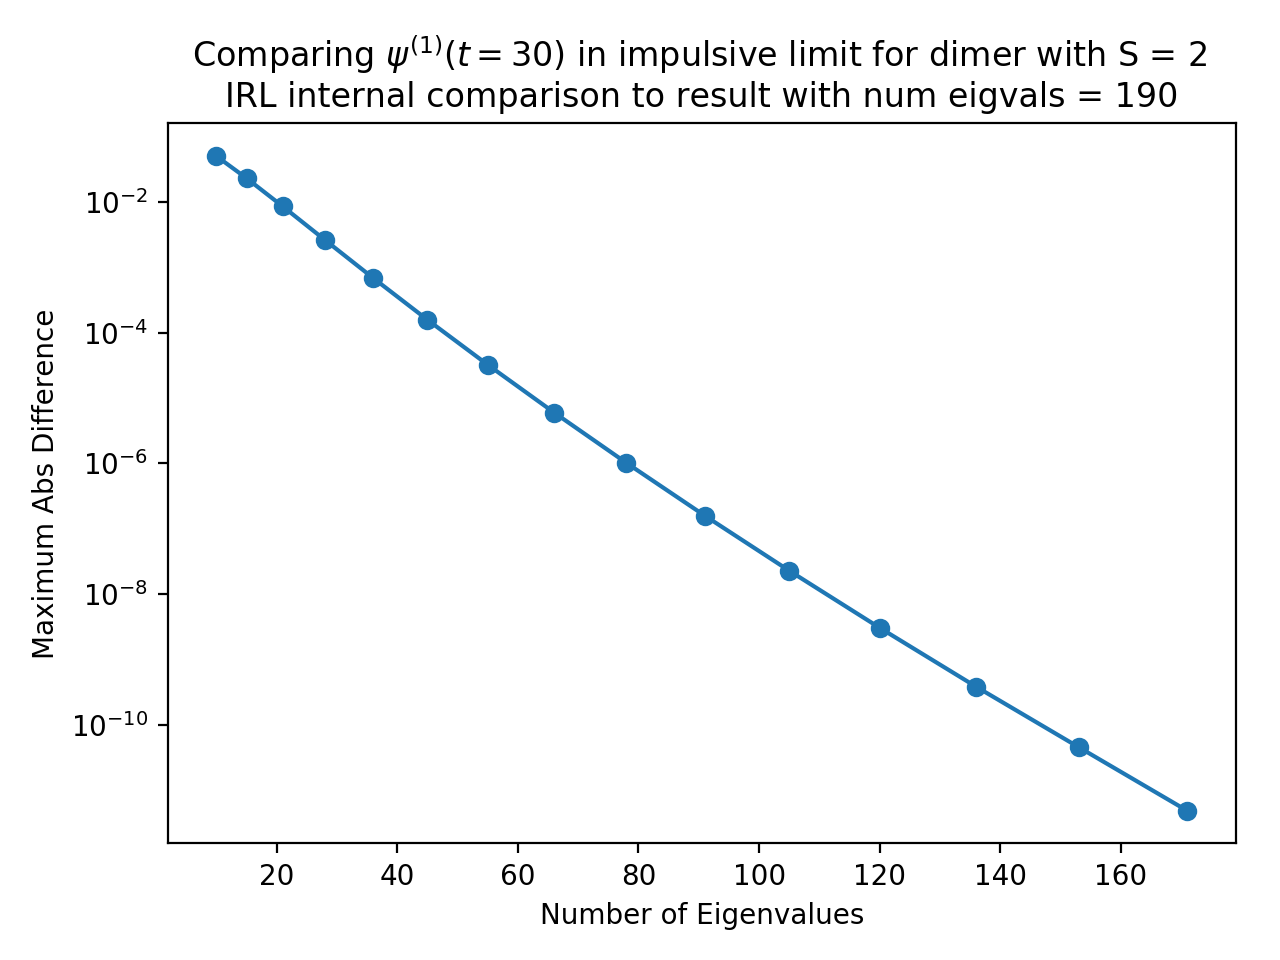

<IPython.core.display.Javascript object>


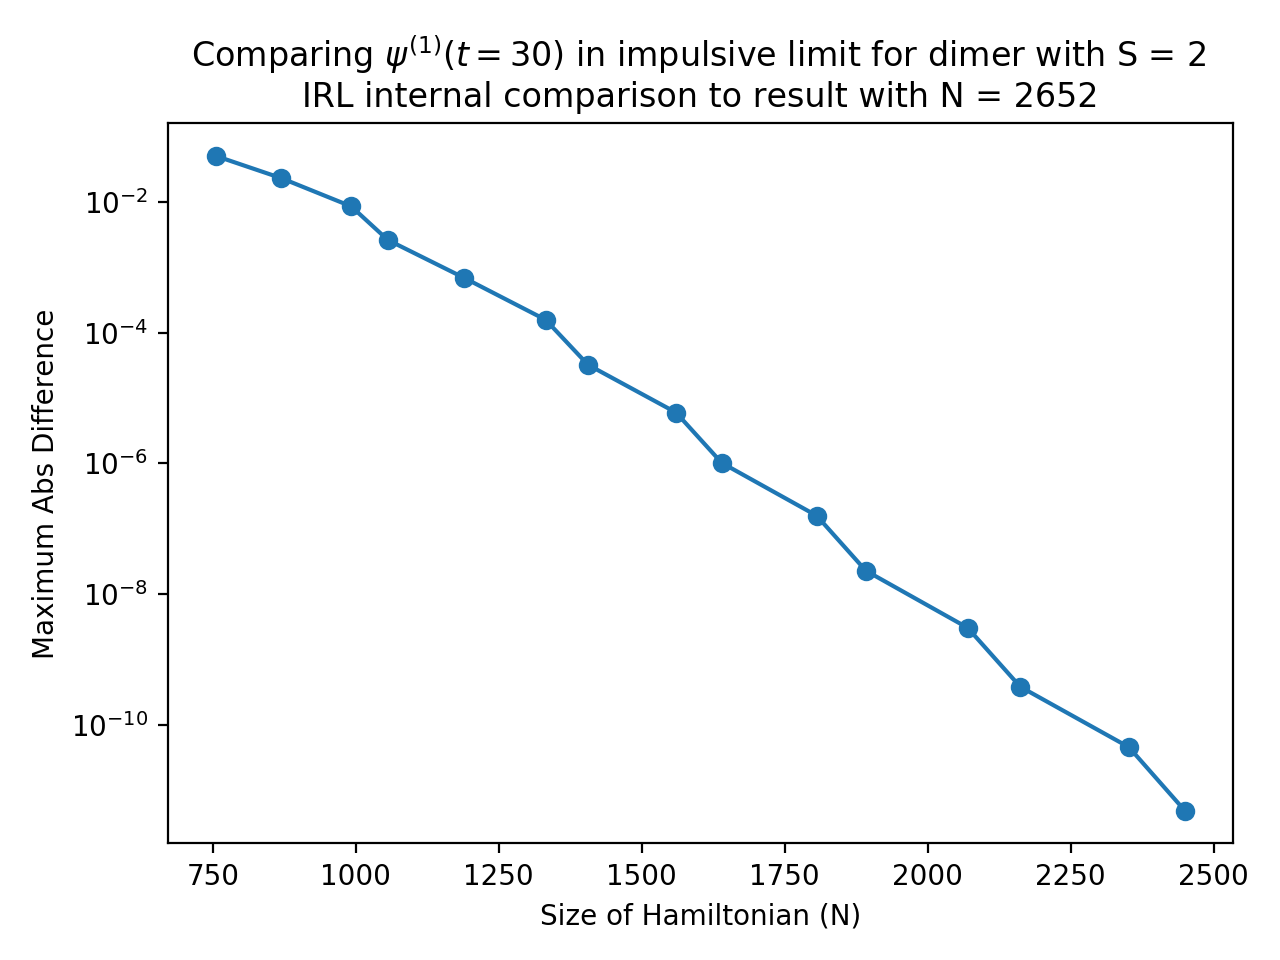

<IPython.core.display.Javascript object>


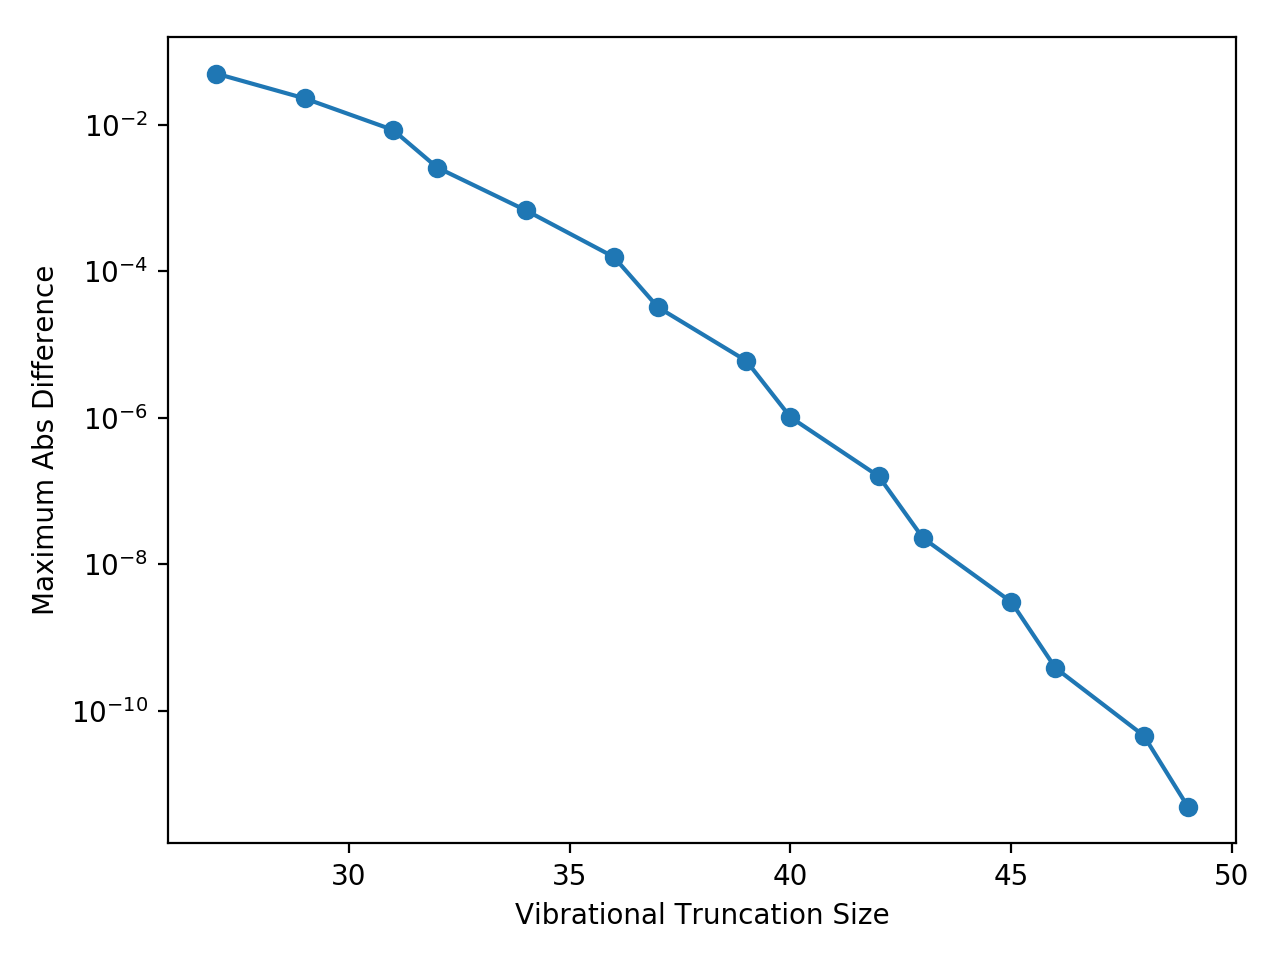

In [133]:
q = -1
y = irl_psi_finals_arr[:q,:] - irl_psi_finals_arr[q,:]
#y = np.mean(np.abs(y),axis=1)
#y = np.max(np.abs(y),axis=1)
y = np.abs(y[:,0])
x = num_eigvals[:q]
x2 = act_sizes[:q]
x3 = trunc_sizes[:q]
fig, ax = plt.subplots()
ax.semilogy(x,y,'-o')
plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
         'IRL internal comparison to result with num eigvals = {}'.format(int(num_eigvals[-1])))
ax.set_ylabel('Maximum Abs Difference')
ax.set_xlabel('Number of Eigenvalues')
plt.tight_layout()

fig, ax = plt.subplots()
ax.semilogy(x2,y,'-o')
plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
         'IRL internal comparison to result with N = {}'.format(int(act_sizes[-1])))
ax.set_ylabel('Maximum Abs Difference')
ax.set_xlabel('Size of Hamiltonian (N)')
plt.tight_layout()

fig, ax = plt.subplots()
ax.semilogy(x3,y,'-o')
#plt.title('Comparing $\psi^{(1)}(t=30)$ in impulsive limit for dimer with S = 2 \n' + 
#         'Full eigh comparison to result with N = {}'.format(int(act_sizes[-1])))
ax.set_ylabel('Maximum Abs Difference')
ax.set_xlabel('Vibrational Truncation Size')
plt.tight_layout()

In [71]:
i = 4
rk.set_H(truncation_size=trunc_sizes[i])
act_size = rk.H1.shape[0]
rk.set_IRL_eigensystem(num = num_eigvals[i],tol = 0)
e1 = copy.deepcopy(rk.eigenvalues[1])
v1 = copy.deepcopy(rk.eigenvectors[1])
rk.set_full_eigensystem()
rk.truncate_full_eigensystem(num_eigvals[i])
e1b = copy.deepcopy(rk.eigenvalues[1])
v1b = copy.deepcopy(rk.eigenvectors[1])
print(np.allclose(e1,e1b),np.allclose(v1,v1b))

True False


In [74]:
np.unravel_index(np.argmax(np.abs(v1-v1b)),v1b.shape)

(42, 0)

In [75]:
print(v1[42,0],v1b[42,0])

-0.520555940961 0.520555940961


In [ ]:
num_eigvals = [10,30,100,300,1000]
eigvals_max_occ_per_mode = [3,5,8,12,18]
converged_by_sizes = [9,11,14,18]

In [161]:
f(18,3)

1140.0